## Tutorial 4
Solving the 1D unsteady diffusion equation using a Physics Informed Neural Network (PINN).  
The Equation is given by:
$$\frac {\partial u} {\partial t} - \mu \frac {\partial^2 u} {\partial x^2} = 0$$
The Domain for $x$ and $t$ are $x\in [0,1]$, and $t\in [0,1]$.  
The ICs/BSs are (here $T=1$):
$$u(x,t=0)=sin(\frac {2\pi x} {T})$$
$$u(x=0,t)=0$$
$$u(x=1,t)=0$$
$$u_x(x=0,t)=u_x(x=1,t)$$


In [1]:
import torch
import torch.nn as nn
from torch.autograd import grad
import torch.functional as F
import numpy as np
import matplotlib.pyplot as plt
#whatsapp
#houwudoin
#hidsadsadsa
#ddgvsvcvvvvvdsadsadsadsaddsa
#dsadsadsdsa

### Define PINNs network class with Fourier Feature Mapping

In [2]:
class ffm(nn.Module):
    def __init__(self, in_dim, out_dim, std_dev = 10):
        super().__init__()
        self.omega = nn.Parameter(torch.randn(out_dim, in_dim) * std_dev) # Length of hidden layer is rows, 

    def forward(self, x):
        return torch.cos(F.F.linear(x, self.omega))

class PINNs_net(nn.Module):    
    def __init__(self, in_dim=2, HL_dim=32, out_dim=3, activation=nn.Tanh()):
        """
        Parameters
        -------------
        in_dim: the input dimensions - number of independant variables
        HL_dim: the width of the network
        out_dim: the output dimensions - number of dependant variables
        activation: The activation function you wish to use in the network - the default is nn.Tanh()
        """
        super().__init__()
        
        # define the network architecture
        network = [nn.Linear(in_dim, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, out_dim)]
        '''network = [ffm(in_dim, HL_dim),
                   nn.Linear(in_dim, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, out_dim)]'''
        
        # define the network using sequential method
        self.net = nn.Sequential(*network) 
    
    def forward(self, x, y):
        return self.net(torch.cat((x, y), 1))
    
    
    def compute_loss(self, x, y, Nx, Ny, u_i):
        """
        This is the physics part really
        """
        Re = 100
        x.requires_grad=True
        y.requires_grad=True
        net_out = self.net(torch.cat((x,y), 1))   # input size: [Nx*Ny,2], output size: [Nx*Ny,3]

        u = net_out[:,0]
        v = net_out[:,1]
        p = net_out[:,2]
        print(type(u))
        # u.requires_grad=True
        # v.requires_grad=True
        # p.requires_grad=True

        # compute PDE derivatives using auto grad
        # we need to specify the dimension of the output array
        u_x = grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_y = grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_yy = grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

        v_x = grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]  # Change 5: Added gradients for v
        v_y = grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_xx = grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
        v_yy = grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]

        p_x = grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        p_y = grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]

        # set a loss function to apply to each of the physics residuals (PDE, IC, BC)
        loss_fun = nn.MSELoss()

        # compute the PDE residual loss
        res1 = u_x + v_y
        res2 = u*u_x + v*u_y + p_x - 1/Re*(u_xx+u_yy)
        res3 = u*v_x + v*v_y + p_y - 1/Re*(v_xx+v_yy)
        pde_loss = loss_fun(res1, torch.zeros_like(res1)) + loss_fun(res2, torch.zeros_like(res2)) + loss_fun(res3, torch.zeros_like(res3))

        # compute the BC loss
        u_reshaped = u.view(Nx, Ny) # [Nx*Ny, 1] -> [Nx, Nt]
        #u_x_reshaped = u_x.view(Nx, Ny) # [Nx*Ny, 1] -> [Nx, Nt]
        v_reshaped = v.view(Nx, Ny) # [Nx*Ny, 1] -> [Nx, Nt]
        #v_x_reshaped = v_x.view(Nx, Ny) # [Nx*Ny, 1] -> [Nx, Nt]
        #u_reshaped = u.view(Nx, Ny) # [Nx*Ny, 1] -> [Nx, Nt]
        #u_x_reshaped = u_x.view(Nx, Ny) # [Nx*Ny, 1] -> [Nx, Nt]
        bc_loss = loss_fun(u_reshaped[0, :], torch.zeros_like(u_reshaped[0,:])) \
                + loss_fun(u_reshaped[Nx-1, :], torch.zeros_like(u_reshaped[Nx-1,:])) \
                + loss_fun(v_reshaped[0, :], torch.zeros_like(v_reshaped[0,:])) \
                + loss_fun(v_reshaped[Nx-1, :], torch.zeros_like(v_reshaped[Nx-1,:])) \
                + loss_fun(u_reshaped[:, Ny-1], torch.zeros_like(u_reshaped[:,Ny-1])) \
                + loss_fun(v_reshaped[:,Ny-1], torch.zeros_like(v_reshaped[:,Ny-1])) \
                + loss_fun(u_reshaped[:, 0], u_i * torch.ones_like(u_reshaped[:,0])) \
                + loss_fun(v_reshaped[:, 0], torch.zeros_like(v_reshaped[:,0])) \
        
    
        return pde_loss, bc_loss


### Define Model and Optimizer

In [3]:
model = PINNs_net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Setting up the Case

In [4]:
# num of points in the domain
Nx, Ny = 64, 64
u_i = 10 #m/s
# define domain dimensions and resolution
Lx_initial, Lx_final = 0, 1
Ly_initial, Ly_final = 0, 1
dx = (Lx_final - Lx_initial) / (Nx - 1)
dy = (Ly_final - Ly_initial) / (Ny-1)

# initiallize input parameters as tensors
x = torch.zeros(Nx, Ny)
y = torch.zeros(Nx, Ny)
for i in range(Nx):
    for j in range(Ny):
        x[i,j] = Lx_initial + dx * i
        y[i,j] = Ly_initial + dy * j


### Training the PINNs network

In [5]:
for epoch in range(300):
    # compute various losses
    eq_loss, BC_loss = model.compute_loss(x.view(-1,1), y.view(-1,1), Nx, Ny , u_i)

    # compute total loss
    total_loss = eq_loss + 20*BC_loss

    # backward pass
    total_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print(f"epoch: {epoch}, loss: {total_loss}")


<class 'torch.Tensor'>
epoch: 0, loss: 1991.1240234375
<class 'torch.Tensor'>
epoch: 1, loss: 1977.282470703125
<class 'torch.Tensor'>
epoch: 2, loss: 1963.7796630859375
<class 'torch.Tensor'>
epoch: 3, loss: 1950.52197265625
<class 'torch.Tensor'>
epoch: 4, loss: 1937.388427734375
<class 'torch.Tensor'>
epoch: 5, loss: 1924.264404296875
<class 'torch.Tensor'>
epoch: 6, loss: 1911.0440673828125
<class 'torch.Tensor'>
epoch: 7, loss: 1897.6319580078125
<class 'torch.Tensor'>
epoch: 8, loss: 1883.946044921875
<class 'torch.Tensor'>
epoch: 9, loss: 1869.913330078125
<class 'torch.Tensor'>
epoch: 10, loss: 1855.4696044921875
<class 'torch.Tensor'>
epoch: 11, loss: 1840.562744140625
<class 'torch.Tensor'>
epoch: 12, loss: 1825.1524658203125
<class 'torch.Tensor'>
epoch: 13, loss: 1809.21142578125
<class 'torch.Tensor'>
epoch: 14, loss: 1792.7239990234375
<class 'torch.Tensor'>
epoch: 15, loss: 1775.6878662109375
<class 'torch.Tensor'>
epoch: 16, loss: 1758.1168212890625
<class 'torch.Tensor

torch.Size([4096, 3])
u:  torch.Size([4096])
v:  torch.Size([4096])
x_np:  (4096, 4096)
x:  torch.Size([64, 64])
u_np:  (64, 64)
v max:  tensor(0.0367, grad_fn=<MaxBackward1>)
v_np max:  0.03669504
u max:  tensor(9.3344, grad_fn=<MaxBackward1>)
u_np max:  9.334372


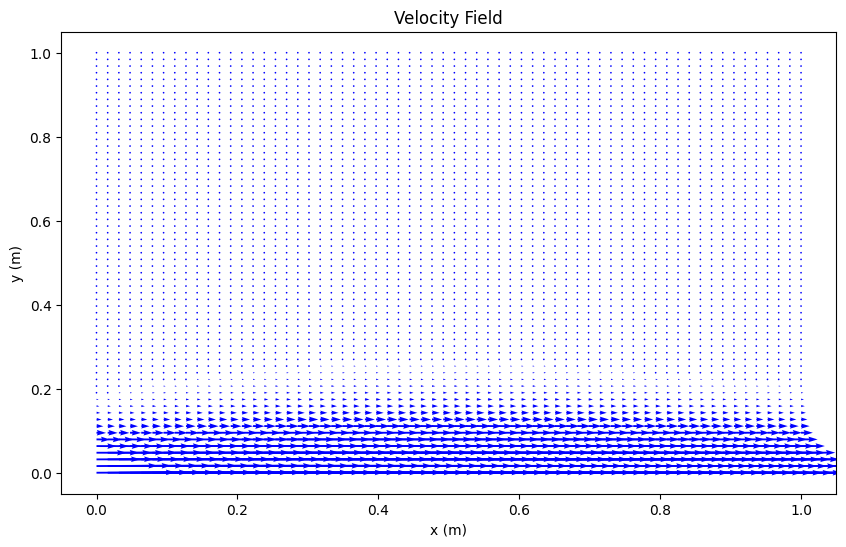

In [10]:
x_np, y_np = np.meshgrid(x, y)
net = model.forward(x.view(-1,1), y.view(-1,1)) # convert x tensor into a column vector
print(net.shape)
u=net[:, 0]
v=net[:, 1]
print("u: ",u.shape)
print("v: ",v.shape)

print("x_np: ",x_np.shape)
print("x: ",x.shape)

u_np = u.detach().numpy().reshape(Nx,Ny) # convert into a np array
print("u_np: ",u_np.shape)

v_np = v.detach().numpy().reshape(Nx,Ny) # convert into a np array
print("v max: ", v.max())
print("v_np max: ", v_np.max())
print("u max: ", u.max())
print("u_np max: ", u_np.max())
plt.figure(figsize=(10, 6))
plt.quiver(x, y, u_np, v_np, color='blue')
plt.title("Velocity Field")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()
#plt.imshow(net_reshaped[:,:], cmap='jet')
# plt.title("Solution for $u(x,y)$ over time")
# plt.colorbar()
# plt.xlabel("y (m)")
# plt.ylabel("x (m)")
# plt.show()



In [7]:

x_np, y_np = np.meshgrid(x, y)

# Flatten x and y for the model input
x_flat = torch.tensor(x_np.flatten(), dtype=torch.float32)
y_flat = torch.tensor(y_np.flatten(), dtype=torch.float32)

# Stack the flattened tensors for the model input
xy_stack = torch.stack((x_flat, y_flat), dim=1)

# Forward pass through the model
net = model.forward(xy_stack)

# Extract u and v components from the network output
u = net[:, 0]
v = net[:, 1]

# Convert u and v to NumPy arrays and reshape them
u_np = u.detach().numpy().reshape(Nx, Ny)
v_np = v.detach().numpy().reshape(Nx, Ny)

# Create a quiver plot
plt.figure(figsize=(10, 6))
plt.quiver(x_np, y_np, u_np, v_np, color='blue')
plt.title("Velocity Field")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()


TypeError: PINNs_net.forward() missing 1 required positional argument: 'y'

In [ ]:
# once you have a complicated solution so the NN is finding it hard to learn functions.
# to enhance the convergance is 
# MLPs can't capture high frequency details. The proposed solution is FFM
# Fourier feature mapping
# PINNs compared to Numerical Solvers is garbage because high frequency data is not captured.
# CFD simulations are usually done in FORTRAN 